# Постановка задачи

Имеются изображения технологического процесса разлива металлических циллиндров. Есть риск нарушения технологии, когда стенки цилиндра не успевают застывать и трескаются. Не застывшый металл выливается, не образуя требуюмую заготовку. Необходимо оперативно определить лунку где произошел пролив. При этом пролив дольно редкое явление. Гораздо больше изображений можно собрать без пролива в лунке.

## Задача: построить модель (на основе автоэнкодера) определяющую состояние лунки пролив\не пролив.

title

Датесет
Данные - вырезанные изображения лунок. Ссыла на даасет

dataset
```
├── proliv  # изображения с проливами
|       ├── 000.jpg
│       ├── 001.jpg
│       │   └── ...
|
├── test  # тестовая выборка где перемешаны проливы и не_проливы
│       ├── imgs
│       │   ├── 000.jpg
│       │   ├── 001.jpg
│       │   └── ...
│       └── test_annotation.txt
|
├── train  #  обучающая выборка из не_проливов
|       ├── 000.jpg
│       ├── 001.jpg
│       └── ...
```
## План решения
- Имплементировать или найти автоэкодер (можно для старта взять пример из лекции по автоэнкодерам)
- Обучаем автоэнкодер на не_проливах (dataset\train)
- Если через такой автоэнкодер прогнать изображение пролива, то MSE между входным изображением и выходным будет больше, чем если прогнать изображение без пролива. Следовательно, если определить некторое пороговое значение MSE, можно классифицировать изображение на классы пролив\не_пролив. Если MSE между входной картинкой и выходной больше фиксированного порога, то на изображении пролив.
- В качестве loss функции используем MSE (как минимум для baseline)
- Для определения порога используем изображения из dataset\proliv
- Пишем метод классификации лунок
- На изображениях из dataset\test тестируем качество. Считаем True_positive_rate и True_negative_rate.
- Цель: получить на тесте максимизаровать метрики True_positive_rate и True_negative_rate (получить более 91% по каждой)


# Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.nn.functional as F

In [3]:
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, Callback


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

In [4]:
import matplotlib.patches as patches
from torchvision.transforms import ToPILImage
from PIL import Image

In [5]:
from glob import glob

In [6]:
np.seed = 42
torch.seed = 42

# Data

## utils

In [7]:
batch_size = 256
num_workers = 6

In [8]:
paths = glob('../data/dataset/train/*')

In [9]:
def cacl_meta(paths: list[str]):
    shapes = []
    values = []
    for path in paths:
        img = cv2.imread(path)
        shapes.append(img.shape)
        values.append(img.mean((0, 1)))
    print(f"px mean: {np.mean(values, 0)}")
    print(f"px std{np.std(values, 0)}")
    print(f"hw mean: {np.mean(shapes, 0)}")
    print(f"hw std: {np.std(shapes, 0)}")
    print(f"hw max: {np.max(shapes, 0)}")

In [10]:
cacl_meta(paths)

px mean: [117.82115343 136.21627219 107.96166175]
px std[5.52291506 5.73441297 4.60631175]
hw mean: [27.2345 48.2663  3.    ]
hw std: [1.82765143 1.52117859 0.        ]
hw max: [40 57  3]


In [11]:
cacl_meta(glob('../data/dataset/proliv/*'))

px mean: [121.69297908 136.76800765 108.14422379]
px std[2.28159659 3.02662478 2.63439014]
hw mean: [28.30519481 48.96753247  3.        ]
hw std: [0.53849142 0.71549484 0.        ]
hw max: [30 51  3]


In [12]:
cacl_meta(glob('../data/dataset/test/imgs/*.jpg'))

px mean: [117.66760402 137.31084869 108.96859242]
px std[7.45812867 7.91534315 6.19017037]
hw mean: [28.77148129 49.83052188  3.        ]
hw std: [2.64679087 2.2472396  0.        ]
hw max: [40 72  3]


In [13]:
SHAPE = (64, 64)

In [16]:
# попробуем 0-1 нормализацию
train_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
    AddGaussianNoise(0, 0.01),
])

val_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

In [17]:
class AnomalyDataset(Dataset):
    def __init__(self, paths: list[str], transforms: transforms.Compose):
        self.paths = paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert('L')
        tensor = self.transforms(img)
        return tensor
        

In [18]:
test_fnames = []
gt_labels = []
with open('../data/dataset/test/test_annotation.txt', 'r') as f:
    for line in f.readlines():
        fname, label = line.split()
        test_fnames.append(f"../data/dataset/test/imgs/{fname}")
        gt_labels.append(int(label))

In [19]:
class TestAnomalyDataset(Dataset):
    def __init__(self, paths: list[str], labels: list[int], transforms: transforms.Compose):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert('L')
        label = self.labels[i]
        tensor = self.transforms(img)
        return tensor, label

In [20]:
train_paths, val_paths = train_test_split(paths, test_size=0.1, random_state=111111)

In [21]:
train_set = AnomalyDataset(train_paths, train_transforms)
val_set = AnomalyDataset(val_paths, val_transforms)
test_set = TestAnomalyDataset(test_fnames, gt_labels, val_transforms)

In [22]:
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [23]:
proliv_dataset = AnomalyDataset(glob('../data/dataset/proliv/*.jpg'), val_transforms)
proliv_loader = DataLoader(proliv_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [24]:
for images in train_loader:
    break

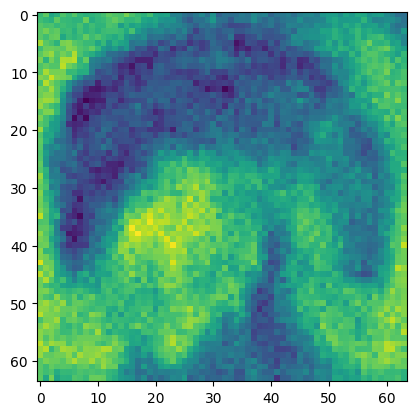

In [25]:
plt.imshow(images[0][0])

In [26]:
for images in proliv_loader:
    break

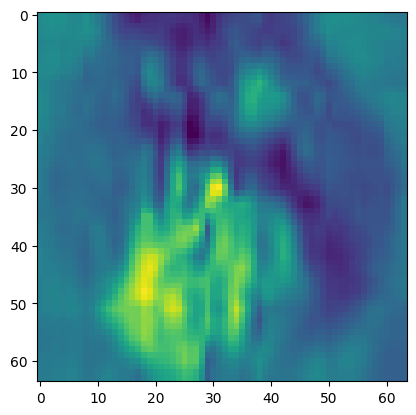

In [27]:
plt.imshow(images[0][0])

In [28]:
for images, labels in test_loader:
    break

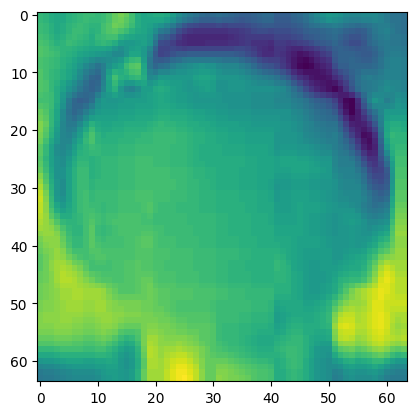

In [29]:
plt.imshow(images[labels==1][0][0])

# Model

## Simple autoencoder

### Encoder

In [31]:
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        super(GatedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.gate_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.conv(x) * self.sigmoid(self.gate_conv(x))

In [32]:
class GatedEncoder(nn.Module):
    def __init__(self):
        super(GatedEncoder, self).__init__()
        self.encoder = nn.Sequential(
            GatedConv2d(1, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            
            GatedConv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
        )

    def forward(self, x):
        return self.encoder(x)

In [96]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [97]:
encoder = GatedEncoder()
decoder = Decoder()
z = encoder(images)
print(z.shape)
out = decoder(z)
print(out.shape)
assert out.shape == images.shape

torch.Size([154, 32, 16, 16])
torch.Size([154, 1, 64, 64])


In [98]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [100]:
# оставлю на память
# class VAE(nn.Module):
#     def __init__(self):
#         super(VAE, self).__init__()

#         self.encoder = Encoder(latent_dim)

#         self.fc_mu = nn.Linear(latent_dim, latent_dim)
#         self.fc_logvar = nn.Linear(latent_dim, latent_dim)

#         self.decoder = Decoder(latent_dim)

#     def encode(self, x):
#         z = self.encoder(x)
#         return self.fc_mu(z), self.fc_logvar(z)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std


#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         return self.decoder(z), mu, logvar

# class LModuleVAE(L.LightningModule):
#     def __init__(self, model: nn.Module):
#         super(LModuleVAE, self).__init__()
#         self.model = model

#     def forward(self, x):
#         recon_x, _, _ = self.model(x)
#         return recon_x

#     def training_step(self, images, batch_idx):
#         recon_images, mu, logvar = self.model(images)
#         loss = self.vae_loss(recon_images, images, mu, logvar)
#         self.log('loss/train', loss)
#         return loss

#     def validation_step(self, images, batch_idx):
#         recon_images, mu, logvar = self.model(images)
#         loss = self.vae_loss(recon_images, images, mu, logvar)
#         self.log('loss/val', loss)

#     def configure_optimizers(self):
#         return torch.optim.AdamW(self.parameters(), lr=3e-4)

#     def vae_loss(self, recon_x, x, mu, logvar):
#         # Реконструкционная потеря
#         mse = F.mse_loss(recon_x, x, reduction='sum')
#         # KL дивергенция
#         kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#         return mse + kl_div


# Training loop

In [101]:
class CalculateThresholdCallback(Callback):
    def __init__(self, every_n_epochs, val_loader, proliv_loader):
        self.every_n_epochs = every_n_epochs
        self.val_loader = val_loader
        self.proliv_loader = proliv_loader
        
    def on_train_epoch_end(self, trainer, pl_module):
        if not trainer.current_epoch % self.every_n_epochs == 0:
            return

        mse_normal = self.calculate_mse_for_loader(pl_module.model, self.val_loader, pl_module.device)
        mse_anomaly = self.calculate_mse_for_loader(pl_module.model, self.proliv_loader, pl_module.device)

        labels = np.array([0] * len(mse_normal) + [1] * len(mse_anomaly))
        mse_values = np.concatenate([mse_normal, mse_anomaly])
        fpr, tpr, thresholds = roc_curve(labels, mse_values)
        roc_auc = auc(fpr, tpr)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        pl_module.log('roc_auc', roc_auc)
        pl_module.log('opt_thresh', optimal_threshold)
        pl_module.optimal_threshold = optimal_threshold

    @staticmethod
    def calculate_mse_for_loader(model, loader, device):
        mse_values = []
        model.eval()
        with torch.no_grad():
            for images in loader:
                images = images.to(device)
                outputs = model(images)
                mse = F.huber_loss(outputs, images, reduction='none').mean([1, 2, 3])
                mse_values.extend(mse.detach().cpu().numpy())
        model.train()
        return np.array(mse_values)

In [102]:
# не совсем честно, добавил это, чтобы понять причину низкого скора на тесте после успешного обучения
class TestAnomalyCallback(Callback):
    def __init__(self, every_n_epochs, test_loader):
        self.every_n_epochs = every_n_epochs
        self.test_loader = test_loader

    def on_train_epoch_end(self, trainer, pl_module):
        if not trainer.current_epoch % self.every_n_epochs == 0:
            return

        

        all_labels = []
        all_preds = []
        pl_module.model.eval()
        for images, labels in self.test_loader:
            with torch.no_grad():
                images = images.to(pl_module.device)
            outputs = pl_module(images)
            mse = F.huber_loss(outputs, images, reduction='none').mean([1, 2, 3])
            preds = mse > pl_module.optimal_threshold

            all_labels.extend(labels.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())

        pl_module.model.train()
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)

        pl_module.log('metrics/tpr', tpr)
        pl_module.log('metrics/tnr', tnr)
        pl_module.log('metrics/mean', (tpr+tnr)/2)

In [113]:
class LModule(L.LightningModule):
    def __init__(self, model: nn.Module):
        super(LModule, self).__init__()
        self.model = model
        self.loss = nn.HuberLoss() 
        self.optimal_threshold = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, images, batch_idx):
        outputs = self.model(images)
        loss = self.loss(outputs, images)
        self.log('loss/train', loss)
        return loss

    def validation_step(self, images, batch_idx):
        outputs = self.model(images)
        loss = self.loss(outputs, images)
        
        self.log('loss/val', loss)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=3e-5)

In [115]:
every_n_epochs = 5

In [116]:
eval_callback = CalculateThresholdCallback(every_n_epochs=every_n_epochs, val_loader=val_loader, proliv_loader=proliv_loader)
test_callback = TestAnomalyCallback(every_n_epochs=every_n_epochs, test_loader=test_loader)

In [117]:
callbacks = [eval_callback, test_callback]

In [118]:
max_epochs = 45
log_every_n_steps = 100

In [119]:
model = Autoencoder(GatedEncoder(), Decoder())

In [120]:
module = LModule(model)
trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=max_epochs,
    log_every_n_steps=log_every_n_steps,
    logger=TensorBoardLogger('../logs_hw2', f'gated_huber_loss'),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [121]:
trainer.fit(module, train_loader, val_dataloaders=val_loader)

Missing logger folder: ../logs_hw2/gated_huber_loss_1_l_2_small_lr
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 11.9 K
1 | loss  | HuberLoss   | 0     
--------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.047     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/worker/miniconda3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/home/worker/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [122]:
model.to('cpu')
model.eval()
print()

In [123]:
mse_normal = []
for images in val_loader:
    with torch.inference_mode():
        out = model(images)
        mse = F.huber_loss(out, images, reduction='none').mean([1, 2, 3])
    mse_normal.extend(mse.detach().cpu().numpy())
mse_normal = np.array(mse_normal)

In [126]:
mse_anomaly = []
for images in proliv_loader:
    with torch.inference_mode():
        out = model(images)
        mse = F.huber_loss(out, images, reduction='none').mean([1, 2, 3])
    mse_anomaly.extend(mse.detach().cpu().numpy())
mse_anomaly = np.array(mse_anomaly)

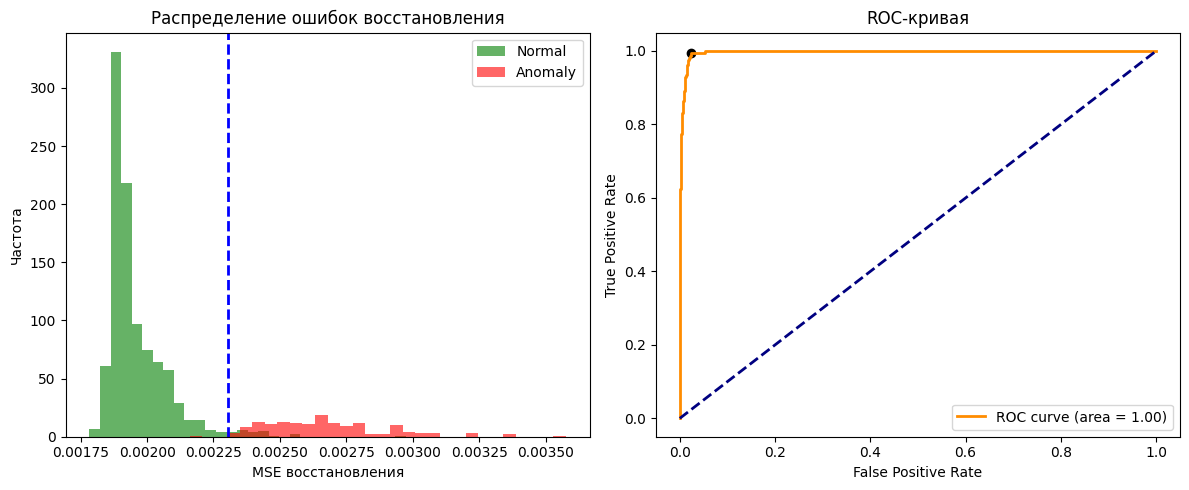

In [128]:
labels = np.array([0] * len(mse_normal) + [1] * len(mse_anomaly))
mse_values = np.concatenate([mse_normal, mse_anomaly])
fpr, tpr, thresholds = roc_curve(labels, mse_values)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(mse_normal, bins=30, alpha=0.6, color='g', label='Normal')
plt.hist(mse_anomaly, bins=30, alpha=0.6, color='r', label='Anomaly')
plt.axvline(optimal_threshold, color='b', linestyle='dashed', linewidth=2)
plt.title('Распределение ошибок восстановления')
plt.xlabel('MSE восстановления')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [129]:
optimal_threshold

0.0023036131

In [130]:
test_annotation = open('../data/dataset/test/test_annotation.txt').readlines()

In [131]:
test_root = '../data/dataset/test/imgs'

In [132]:
test_fnames = []
gt_labels = []
with open('../data/dataset/test/test_annotation.txt', 'r') as f:
    for line in f.readlines():
        fname, label = line.split()
        test_fnames.append(fname)
        gt_labels.append(int(label))

In [133]:
gt_labels = np.array(gt_labels)

In [134]:
pred_errors = []
for fname in test_fnames:
    img = Image.open(f"{test_root}/{fname}").convert('L')
    tensor = val_transforms(img)
    with torch.inference_mode():
        out = model(tensor.unsqueeze(0))
        mse = F.huber_loss(out.squeeze(0), tensor)
        pred_errors.append(mse.item())

In [135]:
pred_errors = np.array(pred_errors)

In [166]:
pred_labels = pred_errors > 0.0022

In [167]:
tn, fp, fn, tp = confusion_matrix(gt_labels, pred_labels).ravel()

# Расчет TPR и TNR
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")

True Positive Rate (TPR): 0.9845
True Negative Rate (TNR): 0.9356


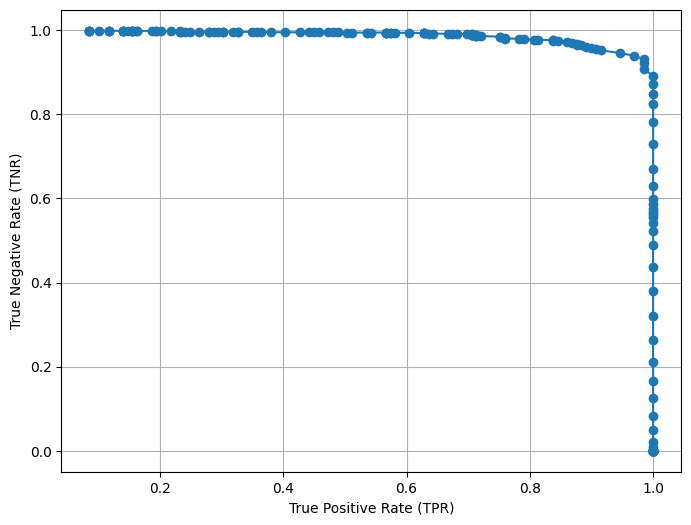

In [138]:
thresholds = np.linspace(optimal_threshold * 0.5, optimal_threshold * 1.5, 200)

tpr_list = []
tnr_list = []

for threshold in thresholds:
    pred_labels = pred_errors > threshold
    tn, fp, fn, tp = confusion_matrix(gt_labels, pred_labels).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    tpr_list.append(tpr)
    tnr_list.append(tnr)

plt.figure(figsize=(8, 6))
plt.plot(tpr_list, tnr_list, marker='o')
plt.xlabel('True Positive Rate (TPR)')
plt.ylabel('True Negative Rate (TNR)')
plt.grid(True)
plt.show()

### артефакты связаны с недообучением, однако, при большем кол-ве эпох модель не может достичь метрик выше 0.85

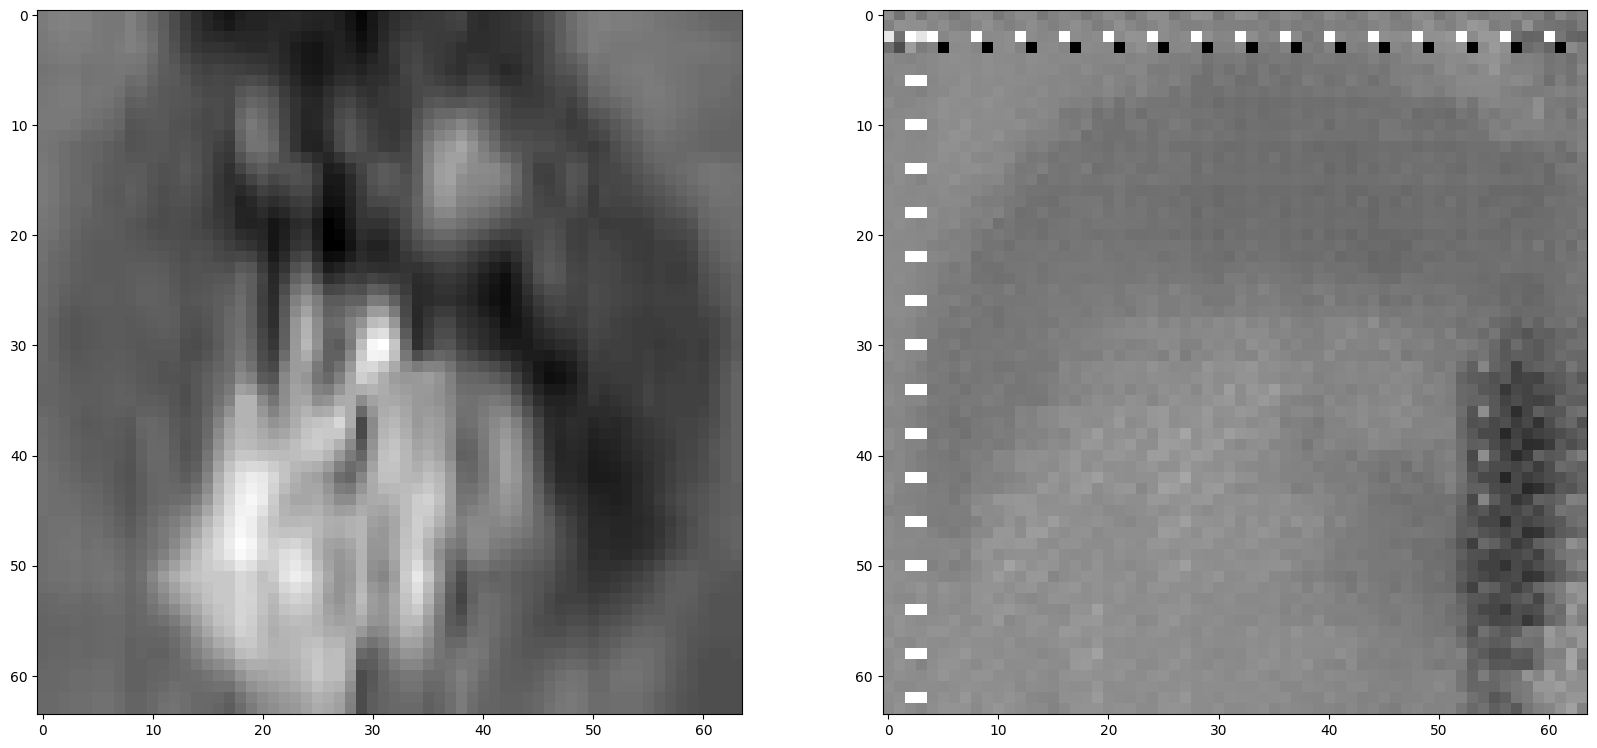

In [155]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 40))

axes[0].imshow(images.detach().cpu().numpy()[0][0], cmap='gray')
axes[1].imshow(out.detach().cpu().numpy()[0][0], cmap='gray')